In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math

In [50]:
dataset = pd.read_csv("seed.txt", sep="\t",
                        names=["feature1", "feature2", "feature3", "feature4", "feature5", "feature6", "feature7", "class"],
                        )
for i in range(7):
    dataset[f"feature{i+1}"] = (dataset[f"feature{i+1}"] - dataset[f"feature{i+1}"].mean()) / dataset[f"feature{i+1}"].std()    
dataset

def find_majority(k):
    myMap = {}
    maximum = ( '', 0 )
    for n in k:
        if n in myMap: myMap[n] += 1
        else: myMap[n] = 1
        if myMap[n] > maximum[1]: maximum = (n,myMap[n])

    return maximum

In [ ]:
class LogisticRegression:
    def __init__(self, data, iteration, alpha):
        self.first_label = list(data["class"].unique())[0]
        self.second_label = list(data["class"].unique())[1]
        self.weights = np.zeros(8,1)
        
        self.X = data.to_numpy()[:,:7]
        self.X = np.c_[self.X, np.ones(self.X.shape[0])]
        self.y = data.to_numpy()[:,7] 
        self.y[self.y == self.first_label] = 0
        self.y[self.y == self.second_label] = 1

        self.cost_list = [0 for i in range(iteration+1)]
        self.iteration = iteration
        self.alpha = alpha
        self.real_iteration = 0
    def hypothesis(self, X):
        return 1 / (1+np.e**(-np.dot(self.weights.T,X)))

    def cost(self):
        m, n = self.X.shape
        total_error = 0
        for i in range(m):
            predicted_value = self.hypothesis(self.X[i])
            likelihood = (self.y[i]*np.log(predicted_value)) + (1-self.y[i]) * np.log(1-predicted_value)
            total_error += likelihood
        return total_error



    def gradient_calc(self):
        m, n = self.X.shape
        weights_gradient = np.zeros(self.weights.shape)
        
        for i in range(n):
            for j in range(m):
                weights_gradient[i] += (self.y[j] - self.hypothesis(self.X[j])) * self.X[j, i]
        return weights_gradient
    
    def train(self):
        m, n = self.X.shape
        iteration = 0
        while True:
            weights_gradient = self.gradient_calc()
            for i in range(n):
                self.weights[i] = self.weights[i] + self.alpha * weights_gradient[i]
            self.cost_list[iteration] = self.cost()[0]
            self.real_iteration = iteration
            iteration+=1
            if iteration >= self.iteration or abs(self.cost_list[iteration-1]-self.cost_list[iteration-2]) <= 0.001:
                break
    
    def draw_cost_function(self):
        x = [i for i in range(0, self.real_iteration+1, 1)]
        plt.plot(x, self.cost_list[:self.real_iteration+1])

In [150]:
class OneVsOne:
    def __init__(self, dataset):
        self.number_of_class = dataset["class"].nunique()
        self.datasets = []
        self.logistic_models = []
        self.train_data, self.test_data = dataset[:int(0.8*len(dataset))], dataset[int(0.8*len(dataset)):]
        # making datasets 
        m , n = 1, 2
        for i in range(self.number_of_class * (self.number_of_class - 1) // 2):
            mask = (self.train_data['class'] == m) | (self.train_data['class'] == n)
            dataset_temp = self.train_data[mask]
            logistic_model = LogisticRegression(dataset_temp, 10000, 0.01)
            self.datasets.append(dataset_temp)
            self.logistic_models.append(logistic_model)
            if (n == self.number_of_class):
                m += 1
                n = m + 1
            else:
                n += 1
    
    def train(self):
        for i in range(self.number_of_class * (self.number_of_class - 1) // 2):
            print (f"{i+1} Classifier")
            self.logistic_models[i].train()
            self.logistic_models[i].draw_cost_function()

    def accuracy_error(self):
        test_true = 0
        X_test = self.test_data.to_numpy()[:,:7]
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        y_test = self.test_data.to_numpy()[:,7] 
        for i in range(len(X_test)):
            predicts = []
            for j in range(self.number_of_class * (self.number_of_class - 1) // 2):
                classifier = self.logistic_models[j]
                logistic_predict = round(classifier.hypothesis(X_test[i])[0])
                if logistic_predict == 1:
                    predicts.append(classifier.second_label)
                else:
                    predicts.append(classifier.first_label)
            if find_majority(predicts)[0] == y_test[i]:
                test_true += 1
        train_true = 0
        X_train = self.train_data.to_numpy()[:,:7]
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        y_train = self.train_data.to_numpy()[:,7] 
        for i in range(len(X_train)):
            predicts = []
            for j in range(self.number_of_class * (self.number_of_class - 1) // 2):
                classifier = self.logistic_models[j]
                logistic_predict = round(classifier.hypothesis(X_train[i])[0])
                if logistic_predict == 1:
                    predicts.append(classifier.second_label)
                else:
                    predicts.append(classifier.first_label)
            if find_majority(predicts)[0] == y_train[i]:
                train_true += 1
            
        print ("Accuracy on test:", (test_true/X_test.shape[0])*100)
        print ("Accuracy on train:",(train_true/X_train.shape[0])*100)
        print ("Error on test:", (1 - test_true/X_test.shape[0])*100)
        print ("Error on train:",(1 - train_true/X_train.shape[0])*100)

    def draw_cost_function(self):
        all_cost = []
        all_iterations = []
        for model in self.logistic_models:
            all_cost.append(model.cost_list)
            all_iterations.append(model.real_iteration)
        cost_sum = [-sum(x)/3 for x in zip(all_cost[0], all_cost[1], all_cost[2])]
        x = [i for i in range(0, max(all_iterations)+1, 1)]
        print(all_iterations)
        plt.plot(x, cost_sum[:max(all_iterations)+1])

1 Classifier
2 Classifier
3 Classifier
Accuracy on test: 97.61904761904762
Accuracy on train: 98.80952380952381
Error on test: 2.3809523809523836
Error on train: 1.1904761904761862


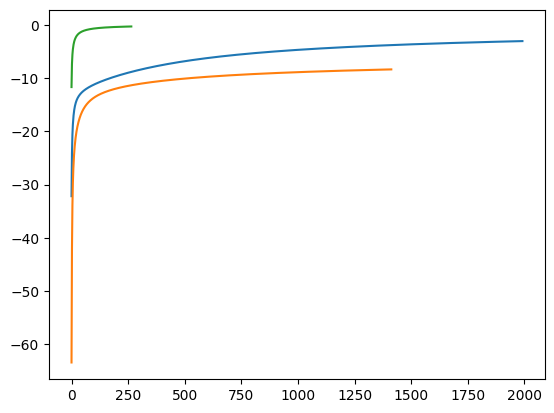

In [151]:
dataset = shuffle(dataset, random_state=0)
OVO = OneVsOne(dataset)
OVO.train()
OVO.accuracy_error()

[1991, 1412, 264]


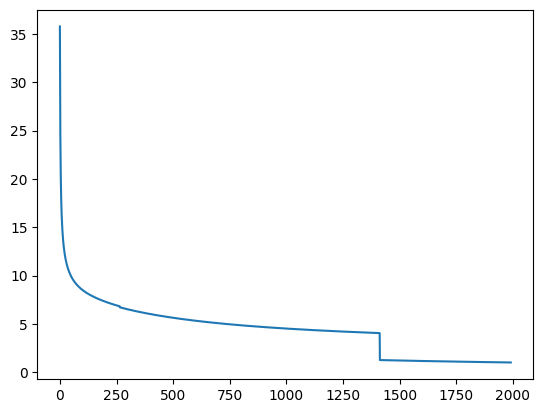

In [152]:
OVO.draw_cost_function()